In [1]:
! pip install -q equinox optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 7.2 MB/s eta 0:00:00


In [2]:
import jax.numpy as jnp
from jax import config, random, vmap
config.update("jax_enable_x64", True)

import requests
from urllib.parse import urlencode

import optax
import equinox as eqx

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/augmentation
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 64 (delta 24), reused 52 (delta 15), pack-reused 0
Unpacking objects: 100% (64/64), 3.80 MiB | 5.16 MiB/s, done.
From https://github.com/VLSF/augmentation
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
from augmentation import D1
from models import UNet, utils

In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/ys7xC3qfLa4CMg'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('elliptic_data.npz', 'wb') as f:
    f.write(download_response.content)

data = jnp.load("/content/elliptic_data.npz")
features = data["features"]
targets = data["targets"]

key = random.PRNGKey(11)
features_, targets_ = D1.augment_dataset(features, targets, key, D1.eliptic_augment_sample, 1)
features_.shape, targets_.shape

((6000, 2, 100), (6000, 1, 100))

# Training without augmentation

In [6]:
input, output = features_[0], targets_[0]

N_convs = 2
depth = 4
input_features = input.shape[0]
internal_features = 10
output_features = output.shape[0]
D = len(input.shape) - 1
kernel_size = 3

key = random.PRNGKey(11)

model = UNet.UNet(D, input.shape[1], [input_features, internal_features, output_features], kernel_size, N_convs, key, depth=depth)

learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 2000, 0.5)
optim = optax.adamw(sc, weight_decay=1e-2)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
chunk_size = 20
N_epoch = 100
Save_each_N = 1000

key = random.PRNGKey(33)
model, opt_state, train_losses, test_losses = utils.training_loop([features_[:2000], targets_[:2000]], [features_[2000:3000], targets_[2000:3000]], model, opt_state, optim, Save_each_N, UNet.make_step, UNet.compute_loss, chunk_size, N_epoch, key)

In [7]:
prediction = vmap(model)(features_[2000:3000])
errors = jnp.linalg.norm(targets_[2000:3000] - prediction, axis=2) / jnp.linalg.norm(targets_[2000:3000], axis=2)

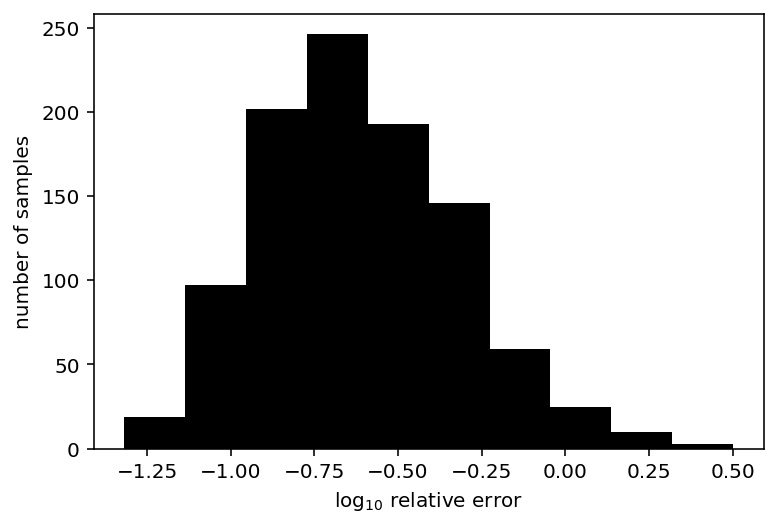

In [8]:
plt.hist(jnp.log10(errors)[:, 0], color="black")
plt.xlabel("$\\log_{10}$ relative error")
plt.ylabel("number of samples");

# Training with augmentation

In [9]:
input, output = features_[0], targets_[0]

N_convs = 2
depth = 4
input_features = input.shape[0]
internal_features = 10
output_features = output.shape[0]
D = len(input.shape) - 1
kernel_size = 3

key = random.PRNGKey(11)

model = UNet.UNet(D, input.shape[1], [input_features, internal_features, output_features], kernel_size, N_convs, key, depth=depth)

learning_rate = 1e-3
sc = optax.exponential_decay(learning_rate, 4000, 0.5)
optim = optax.adamw(sc, weight_decay=1e-2)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
chunk_size = 20
N_epoch = 100
Save_each_N = 1000

key = random.PRNGKey(33)
model, opt_state, train_losses, test_losses = utils.training_loop([jnp.vstack([features_[:2000], features_[3000:5000]]), jnp.vstack([targets_[:2000], targets_[3000:5000]])], [features_[2000:3000], targets_[2000:3000]], model, opt_state, optim, Save_each_N, UNet.make_step, UNet.compute_loss, chunk_size, N_epoch, key)

In [10]:
prediction = vmap(model)(features_[2000:3000])
errors = jnp.linalg.norm(targets_[2000:3000] - prediction, axis=2) / jnp.linalg.norm(targets_[2000:3000], axis=2)

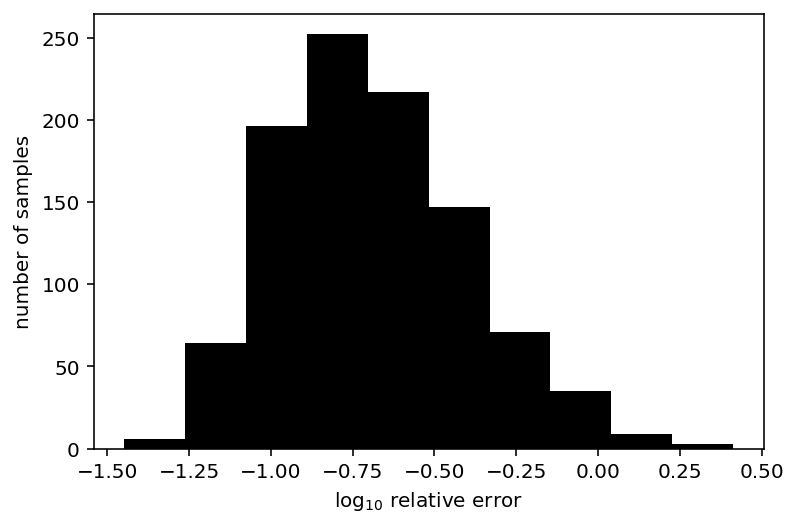

In [11]:
plt.hist(jnp.log10(errors)[:, 0], color="black")
plt.xlabel("$\\log_{10}$ relative error")
plt.ylabel("number of samples");